In [252]:
import numpy as np
import requests, zipfile, io
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import linear_kernel



In [253]:
import numpy as np
import requests, zipfile, io
import pandas as pd


def get_data(url,movies, ratings):
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

    movies = pd.read_csv(movies)
    ratings = pd.read_csv(ratings)
    return movies, ratings

In [254]:
url = "https://files.grouplens.org/datasets/movielens/ml-20m.zip"

In [255]:
movies, ratings = get_data(url ,'ml-20m/movies.csv', 'ml-20m/ratings.csv' )

In [256]:
liste = list(ratings.groupby('userId').agg('count').sort_values(by = 'rating', ascending = False)[:1500].index)

In [262]:
ratings_reduced = ratings[ratings['userId'].isin(liste)]

In [263]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [264]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

In [265]:
def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

In [266]:
bayesian_avg_ratings = ratings.groupby(['movieId'])['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')


In [267]:
movie_stats = movie_stats.merge(movies['movieId'])
best_movies_sorted = movie_stats.sort_values('bayesian_avg', ascending=False)

In [268]:
movies_reduced = movies.merge(right = best_movies_sorted[:1500], on = 'movieId', how = 'right')
movies_reduced.head()

,movieId,title,genres,count,mean,bayesian_avg
0,318,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990,4.431666
1,858,"Godfather, The (1972)",Crime|Drama,41355,4.364732,4.342857
2,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,47006,4.334372,4.315561
3,527,Schindler's List (1993),Drama|War,50054,4.310175,4.292849
4,1221,"Godfather: Part II, The (1974)",Crime|Drama,27398,4.275641,4.245286


In [269]:
df = ratings_reduced
df = pd.merge(df, movies_reduced, on = 'movieId')

In [270]:
df.head()

,userId,movieId,rating,timestamp,title,genres,count,mean,bayesian_avg
0,116,1,3.0,1132711617,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695,3.92124,3.909556
1,156,1,5.0,1037739266,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695,3.92124,3.909556
2,208,1,4.0,940786662,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695,3.92124,3.909556
3,298,1,4.0,992380086,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695,3.92124,3.909556
4,359,1,5.0,1067183252,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,49695,3.92124,3.909556


In [271]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()

In [272]:
liste_itemid = list(df.movieId.unique())
new_itemid = [i for i in range(len(df.movieId.unique()))]
dico_item = dict(zip(liste_itemid, new_itemid))

In [273]:
liste_userid = list(df.userId.unique())
new_userid = [i for i in range(len(df.userId.unique()))]
dico_user = dict(zip(liste_userid, new_userid))

In [274]:
df['new_itemid'] = df.movieId.apply(lambda x : dico_item[x])
df['new_userid'] = df.userId.apply(lambda x : dico_user[x])

In [275]:
df = df.reindex(columns=["new_itemid","new_userid", "rating", "timestamp", "title", "movieId", "userId"])

In [276]:
df.head()

,new_itemid,new_userid,rating,timestamp,title,movieId,userId
0,0,0,3.0,1132711617,Toy Story (1995),1,116
1,0,1,5.0,1037739266,Toy Story (1995),1,156
2,0,2,4.0,940786662,Toy Story (1995),1,208
3,0,3,4.0,992380086,Toy Story (1995),1,298
4,0,4,5.0,1067183252,Toy Story (1995),1,359


In [277]:
count_ratings = df.groupby('rating').count()
count_ratings['perc_total']=round(count_ratings['new_userid']*100/count_ratings['new_userid'].sum(),1)

<Axes: xlabel='rating'>

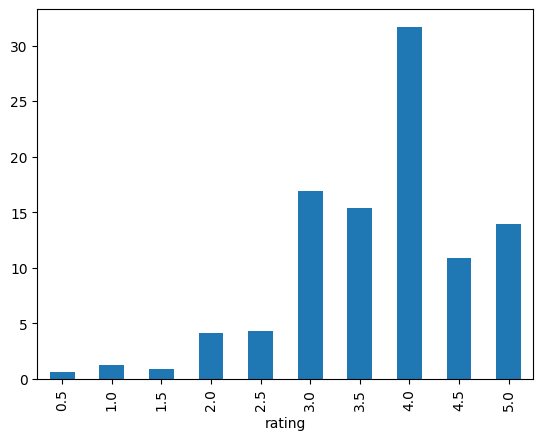

In [278]:
count_ratings['perc_total'].plot.bar()

Movie matrix with genres

In [280]:
def movies_with_genres(movies):
    genre_list = ""
    for index,row in movies.iterrows():
            genre_list += row.genres + "|"
    genre_list_split = genre_list.split('|')
    new_list = list(set(genre_list_split))
    new_list.remove('')

    movies_with_genres = movies.copy()
    for genre in new_list :
        movies_with_genres[genre] = movies_with_genres.apply(lambda _:int(genre in _.genres), axis = 1)
    
    return movies_with_genres

Similarity matrix

In [283]:
# sim matrice
def get_sim_matrice_index(movie):
    movies_genres = movies_with_genres(movie)

    movie_content_df_temp = movies_genres.loc[movies_genres['movieId'].isin(df['movieId'])]
    movie_content_df_temp.set_index('movieId')
    movie_content_df = movie_content_df_temp.drop(columns = ['movieId','title','genres'])
    movie_content_df = movie_content_df.values
    return linear_kernel(movie_content_df,movie_content_df), pd.Series(movie_content_df_temp.index, movie_content_df_temp['title'])

In [284]:
sim , index = get_sim_matrice_index(movies_reduced) # old index 

Neural network with input = user id , movie id

In [356]:
import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Concatenate, Dot
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.losses import mse
from tensorflow.keras.utils import plot_model
from keras.models import load_model

In [287]:
from keras.layers import Concatenate
from keras.constraints import Constraint


class MinMaxConstraint(Constraint):
    
    def __init__(self, x_min=0.1, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max


    def __call__(self, w):
        w_min = tf.minimum(tf.math.reduce_min(w), self.x_min)
        w_max = tf.maximum(tf.math.reduce_max(w), self.x_max)
        scale = (self.x_max - self.x_min) / (w_max - w_min)
        m = self.x_min - w_min * scale
        w = w * scale
        return w + m

    def get_config(self):
        base_config = super().get_config()
        config = {
            "x_min": keras.saving.serialize_keras_object(self.x_min),
            "x_max": keras.saving.serialize_keras_object(self.x_max),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls, config):
        min_config = config.pop("x_min")
        x_min = keras.saving.deserialize_keras_object(min_config)
        max_config = config.pop("x_max")
        x_max = keras.saving.deserialize_keras_object(max_config)
        return cls(x_min,x_max, **config)

In [288]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

reduceLr = ReduceLROnPlateau(monitor = 'val_metric_rating',
                             patience=3,
                             factor = 0.9,
                             verbose=2,
                             mode='min')

reduceLr2 = ReduceLROnPlateau(monitor = 'val_loss',
                             patience=3,
                             factor = 0.5,
                             verbose=2,
                             mode='min')


early_stopping = EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        mode = 'min',
                                        restore_best_weights = True)


In [289]:
@keras.saving.register_keras_serializable()
def metric_rating(y_true, y_pred):
    return tf.keras.metrics.MAE(y_true, y_pred) * 5

In [290]:
len(df.new_userid.unique()), len(df.new_itemid.unique())

(1500, 1500)

In [291]:
df.rating = df.rating/df.rating.max()

In [292]:
df.new_userid = df.new_userid.astype('category').cat.codes.values
df.new_itemid = df.new_itemid.astype('category').cat.codes.values

In [293]:
def split_data_ml100k(data, num_users, num_items, test_ratio):
    mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
    neg_mask = [not x for x in mask]
    train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [294]:
n_users = df.new_userid.nunique()
n_items = df.new_itemid.nunique()

In [295]:
train, test = split_data_ml100k(df, n_users, n_items,0.3)

In [297]:
def nn_model(n_latent_factors_user, n_latent_factors_movie):

    movie_input = Input(shape=[1],name='Item')
    movie_embedding = Embedding(n_items+1 , n_latent_factors_movie,
                                             name='Embedding_Movie')(movie_input)
    movie_vec = Flatten(name='Flatten_Movies')(movie_embedding)

    user_input = Input(shape=[1],name='User')
    movie_embedding = Embedding(n_users+1 , n_latent_factors_user,
                                             name='Embedding_User')(user_input)
    user_vec = Flatten(name='Flatten_Users')(movie_embedding)


    concatted  = Concatenate([movie_vec, user_vec])


    dense_1 = Dense((n_latent_factors_user + n_latent_factors_movie) * 0.6 ,name='Dense_1', activation='relu')(concatted)
    
    result = keras.layers.Dense(1, activation='sigmoid',kernel_constraint=MinMaxConstraint(),name='Output')(dense_1)
  
    model = keras.Model([user_input, movie_input], result)
    model.compile(optimizer="adam", loss="mse",metrics = metric_rating)
    return model

In [298]:
model = nn_model(50,50)

In [299]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [300]:
history_model= model.fit([train.new_userid, train.new_itemid], train.rating, validation_split = 0.2,
                                     callbacks = [reduceLr2,early_stopping],
                                     epochs=20,batch_size = 50, verbose=1)

Epoch 1/20
9686/9686 [==============================] - 24s 2ms/step - loss: 0.0251 - metric_rating: 0.6032 - val_loss: 0.0271 - val_metric_rating: 0.6405 - lr: 0.0010
Epoch 2/20
9686/9686 [==============================] - 23s 2ms/step - loss: 0.0230 - metric_rating: 0.5761 - val_loss: 0.0281 - val_metric_rating: 0.6553 - lr: 0.0010
Epoch 3/20
9686/9686 [==============================] - 23s 2ms/step - loss: 0.0219 - metric_rating: 0.5615 - val_loss: 0.0331 - val_metric_rating: 0.7304 - lr: 0.0010
Epoch 4/20
9684/9686 [============================>.] - ETA: 0s - loss: 0.0210 - metric_rating: 0.5502
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
9686/9686 [==============================] - 23s 2ms/step - loss: 0.0210 - metric_rating: 0.5502 - val_loss: 0.0375 - val_metric_rating: 0.7885 - lr: 0.0010
Epoch 5/20
9686/9686 [==============================] - 23s 2ms/step - loss: 0.0195 - metric_rating: 0.5294 - val_loss: 0.0430 - val_metric_rating: 0.8555 - lr:

In [301]:
model.save('nn1.keras')

In [378]:
nn1 = tf.keras.saving.load_model('nn1.keras', custom_objects={'MinMaxConstraint': MinMaxConstraint})

In [306]:
y_pred = model1.predict([test.new_userid, test.new_itemid]) * 5

8101/8101 [==============================] - 8s 991us/step


In [307]:
pd.DataFrame(y_pred).describe()

,0
count,259211.000000
mean,3.649957
std,0.454248
min,2.321806
25%,3.347209
50%,3.665144
75%,3.970783
max,4.965224


In [308]:
from sklearn.metrics import mean_absolute_error

y_true = test.rating
mean_absolute_error(y_true * 5, y_pred)

0.5978703612406276

In [310]:
train_loss = history_model.history["loss"]
val_loss = history_model.history["val_loss"]
train_acc = history_model.history["metric_rating"]
val_acc = history_model.history["val_metric_rating"]

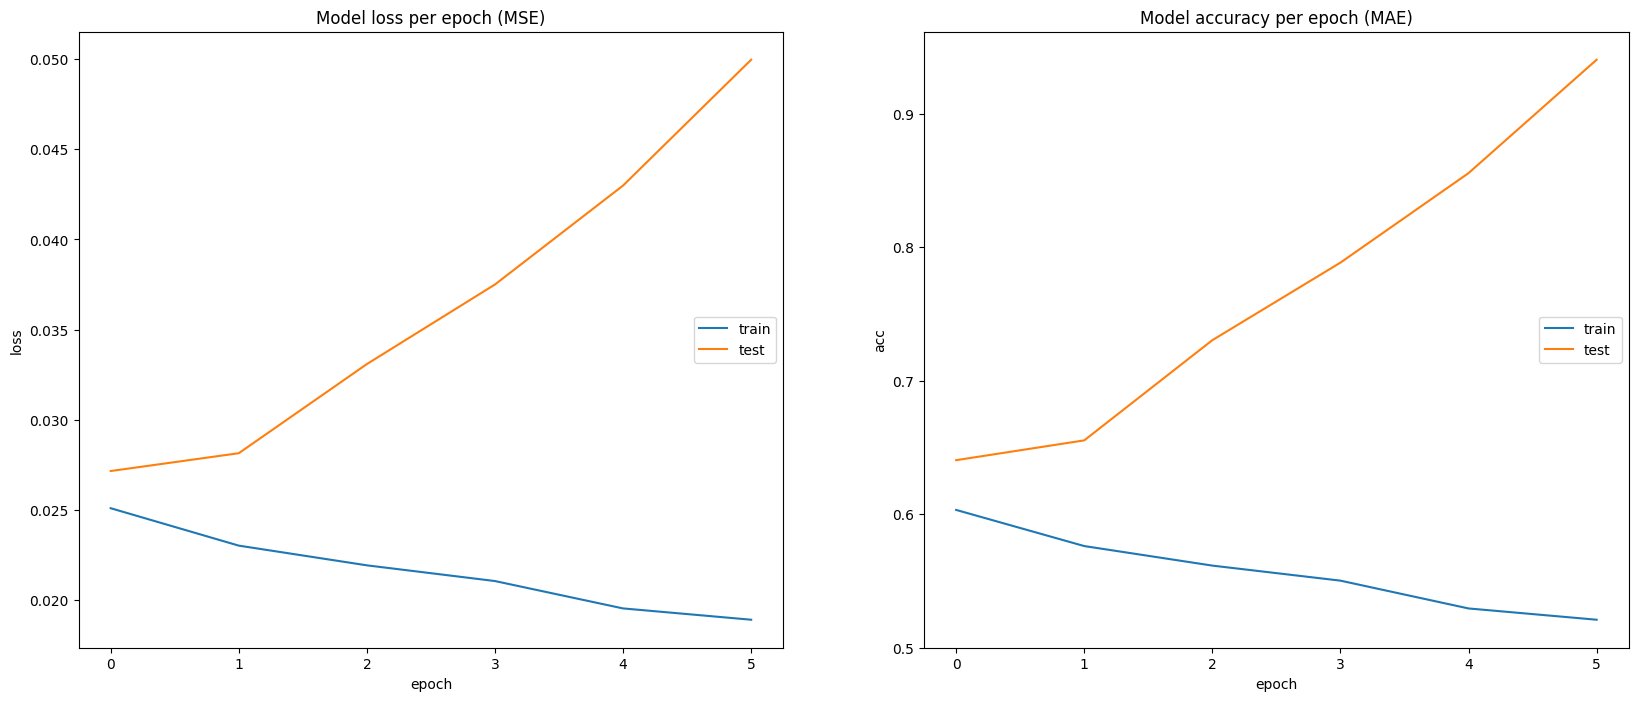

In [311]:
plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch (MAE)')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.show()

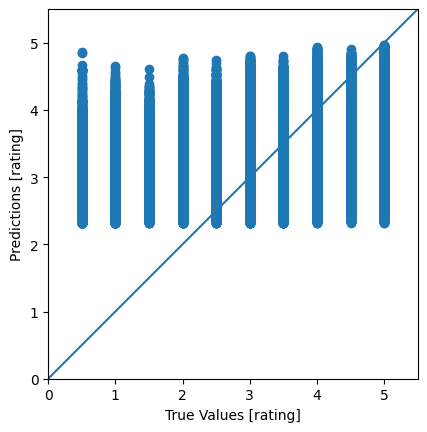

In [312]:
a = plt.axes(aspect='equal')
plt.scatter(y_true * 5, y_pred)
plt.xlabel('True Values [rating]')
plt.ylabel('Predictions [rating]')
lims = [0, 5.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [313]:
df_pred = pd.DataFrame(columns=['rating','pred'])

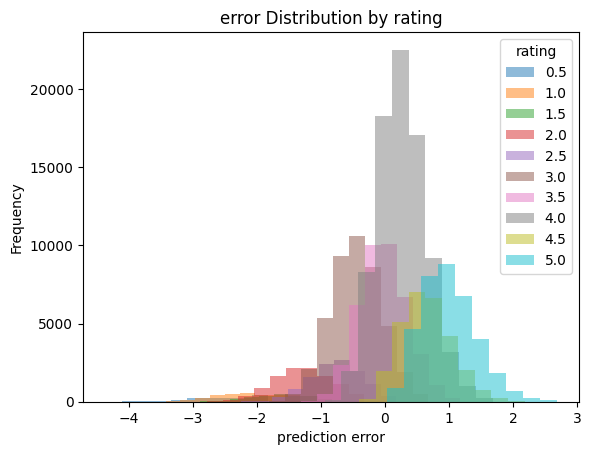

In [314]:
df_pred['rating'] = y_true*5
df_pred['pred'] = y_pred
df_pred['error'] = df_pred['rating'] - df_pred['pred']
liste = sorted(df_pred['rating'].unique())


for j in range(len(liste)):
  plt.hist(df_pred.loc[df_pred['rating'] == liste[j], 'error'], alpha=0.5, label= liste[j])

plt.title('error Distribution by rating')
plt.xlabel('prediction error')
plt.ylabel('Frequency')

plt.legend(title='rating')

Hybrid model (nn + similarity matrix)

In [376]:
def get_hybrid_model(user_index,movie_title,cosine_sim,indicies,model) :
    idx = indicies[movie_title]
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:10]
    movie_indices = [i[0] for i in sim_scores]
    movies = movies_reduced.iloc[movie_indices]
    movies = movies.reset_index()
    index_movies = df[['movieId','new_itemid']].drop_duplicates( keep='first')
    movies = pd.merge(movies,index_movies, on = 'movieId')
    movies['userId'] = user_index
    movies['prediction_rating'] = model.predict([movies.userId, movies.new_itemid])*5
    movies = movies.drop(['userId','movieId','new_itemid'], axis = 1)
    return movies

In [319]:
index

title
Shawshank Redemption, The (1994)                          0
Godfather, The (1972)                                     1
Usual Suspects, The (1995)                                2
Schindler's List (1993)                                   3
Godfather: Part II, The (1974)                            4
                                                       ... 
Strawberry and Chocolate (Fresa y chocolate) (1993)    1495
Legends of the Fall (1994)                             1496
Mirror, The (Zerkalo) (1975)                           1497
Spy Who Loved Me, The (1977)                           1498
Tokyo Godfathers (2003)                                1499
Length: 1500, dtype: int64

In [379]:
get_hybrid_model(0,'Godfather: Part II, The (1974)',sim , index, nn1)

1/1 [==============================] - 0s 334ms/step


,index,title,genres,count,mean,bayesian_avg,prediction_rating
0,90,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000,4.018989,3.234988
1,0,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990,4.431666,3.842893
2,19,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,63299,4.177057,4.164868,3.653421
3,750,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,59715,3.664741,3.658166,2.917204
4,14,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,54502,4.190672,4.176358,3.771194
5,81,Braveheart (1995),Action|Drama|War,53769,4.042534,4.030060,3.474209
6,176,Terminator 2: Judgment Day (1991),Action|Sci-Fi,52244,3.931954,3.920682,3.375961
7,16,"Matrix, The (1999)",Action|Sci-Fi|Thriller,51334,4.187186,4.172052,3.441195
8,3,Schindler's List (1993),Drama|War,50054,4.310175,4.292849,3.344282


NN with user + movies features(idx , genres)

In [321]:
df = pd.merge(df,movies_with_genres(movies_reduced), on = 'movieId')

In [322]:
df.columns

Index(['new_itemid', 'new_userid', 'rating', 'timestamp', 'title_x', 'movieId',
       'userId', 'title_y', 'genres', 'count', 'mean', 'bayesian_avg', 'Crime',
       'Action', 'IMAX', 'Children', 'Drama', 'Musical', 'Comedy', 'Fantasy',
       'Sci-Fi', 'Horror', 'War', 'Documentary', 'Mystery', 'Western',
       'Romance', 'Film-Noir', 'Adventure', 'Animation', 'Thriller'],
      dtype='object')

In [323]:
df = df.reindex(columns=["new_itemid","new_userid", "rating", "timestamp", "title_x", "movieId", "userId",
                              'title_y', 'genres','count', 'mean', 'bayesian_avg', 'title_y', 'genres_y', 'Crime',
                              'Action', 'IMAX', 'Children', 'Drama', 'Musical', 'Comedy', 'Fantasy',
                              'Sci-Fi', 'Horror', 'War', 'Documentary', 'Mystery', 'Western',
                              'Romance', 'Film-Noir', 'Adventure', 'Animation', 'Thriller'])

In [327]:
df2 = df[["new_itemid","new_userid", "rating", "timestamp", "movieId", "userId",'Western',
           'Romance', 'Action', 'Film-Noir', 'Animation', 'Mystery', 'Adventure',
           'Sci-Fi',  'Thriller', 'Horror', 'War', 'Comedy','Children', 'Drama', 'Documentary', 'IMAX', 
           'Crime', 'Musical','Fantasy']]

In [329]:
train, test = split_data_ml100k(df2, n_users, n_items, test_ratio=0.3)

In [330]:
train_user = train['new_userid']
test_user =  test['new_userid']
train_movie = train[['new_itemid','Western','Romance', 'Action', 'Film-Noir', 'Animation', 'Mystery', 'Adventure'
,'Sci-Fi','Thriller', 'Horror', 'War', 'Comedy','Children', 'Drama', 'Documentary', 'IMAX','Crime', 'Musical','Fantasy']]
test_movie = test[['new_itemid','Western','Romance', 'Action', 'Film-Noir', 'Animation', 'Mystery', 'Adventure','Sci-Fi',
'Thriller', 'Horror', 'War', 'Comedy','Children', 'Drama', 'Documentary', 'IMAX','Crime', 'Musical','Fantasy']]

In [336]:
train_movie.shape[1]

20

In [380]:
reduceLr = ReduceLROnPlateau(monitor = 'val_loss',
                             patience=3,
                             factor = 0.9,
                             verbose=2,
                             mode='min')

early_stopping = EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        mode = 'min',
                                        restore_best_weights = True)

In [381]:
def nn_model_with_genre(n_latent_factors_user, n_latent_factors_movie):

    movie_input = Input(shape=[20],name='Item')
    movie_embedding = Embedding(n_items+1 , n_latent_factors_movie,
                                             name='Embedding_Movie')(movie_input)
    movie_vec = Flatten(name='Flatten_Movies')(movie_embedding)

    user_input = Input(shape=[1],name='User')
    user_embedding = Embedding(n_users+1 , n_latent_factors_user * 20,
                                             name='Embedding_User')(user_input)
    user_vec = Flatten(name='Flatten_Users')(user_embedding)


    concatted  = keras.layers.dot([user_vec,movie_vec],axes=1)


    dense_1 = Dense(32 ,name='Dense_1', activation='relu')(movie_input)

    concatted2 = Concatenate()([concatted, dense_1])
    
    result = Dense(1, activation='sigmoid',kernel_constraint=MinMaxConstraint(),name='Output')(concatted2)
  
    model = Model([user_input, movie_input], result)
    model.compile(optimizer="adam", loss="mse",metrics = metric_rating)
    return model

In [382]:
model2 = nn_model_with_genre(50, 50)

In [383]:
history_model2 = model2.fit([train_user, train_movie], train.rating,validation_split = 0.2,epochs=20,batch_size = 50,callbacks = [reduceLr,early_stopping],verbose=1)

Epoch 1/20
9677/9677 [==============================] - 141s 14ms/step - loss: 0.0262 - metric_rating: 0.6124 - val_loss: 0.0245 - val_metric_rating: 0.5883 - lr: 0.0010
Epoch 2/20
9677/9677 [==============================] - 144s 15ms/step - loss: 0.0194 - metric_rating: 0.5290 - val_loss: 0.0246 - val_metric_rating: 0.5993 - lr: 0.0010
Epoch 3/20
9677/9677 [==============================] - 144s 15ms/step - loss: 0.0168 - metric_rating: 0.4928 - val_loss: 0.0249 - val_metric_rating: 0.6028 - lr: 0.0010
Epoch 4/20
9676/9677 [============================>.] - ETA: 0s - loss: 0.0151 - metric_rating: 0.4693
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.
9677/9677 [==============================] - 147s 15ms/step - loss: 0.0151 - metric_rating: 0.4693 - val_loss: 0.0253 - val_metric_rating: 0.6028 - lr: 0.0010
Epoch 5/20
9677/9677 [==============================] - 150s 16ms/step - loss: 0.0139 - metric_rating: 0.4508 - val_loss: 0.0256 - val_metric_rating: 0.

In [384]:
model2.save('nn2.keras')

In [393]:
nn2 = tf.keras.saving.load_model('nn2.keras', custom_objects={'MinMaxConstraint': MinMaxConstraint})

In [387]:
y_pred2 = model2.predict([test_user, test_movie]) * 5
pd.DataFrame(y_pred2).describe()

8119/8119 [==============================] - 9s 1ms/step


,0
count,259778.000000
mean,3.733729
std,0.482477
min,0.884272
25%,3.447786
50%,3.776011
75%,4.065866
max,4.973129


In [388]:
y_true = test.rating
mean_absolute_error(y_true * 5, y_pred2)

0.5660675536465697

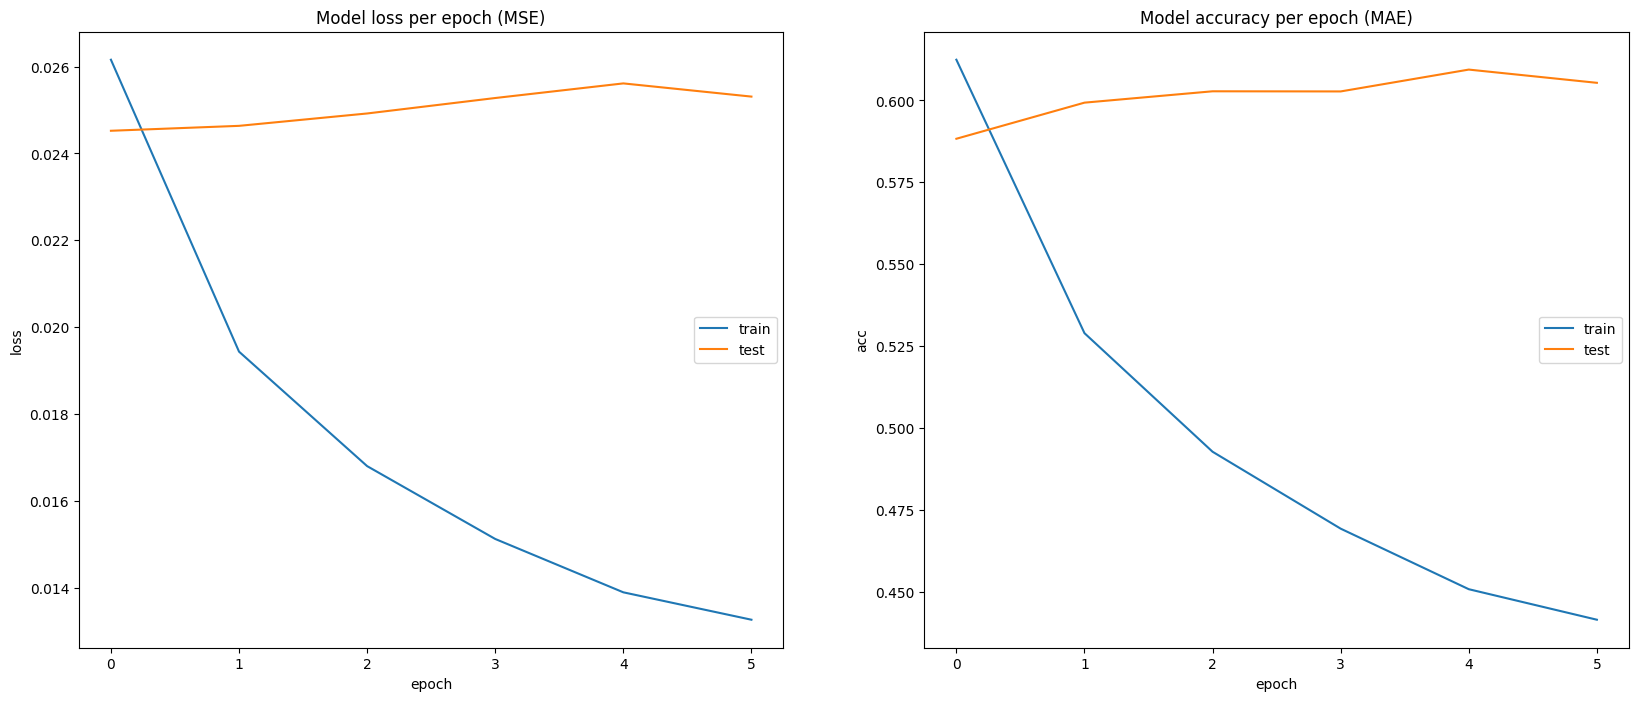

In [389]:
train_loss = history_model2.history["loss"]
val_loss = history_model2.history["val_loss"]
train_acc = history_model2.history["metric_rating"]
val_acc = history_model2.history["val_metric_rating"]

plt.figure(figsize = (20, 8))

plt.subplot(121)
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Model loss per epoch (MSE)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('Model accuracy per epoch (MAE)')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.show()

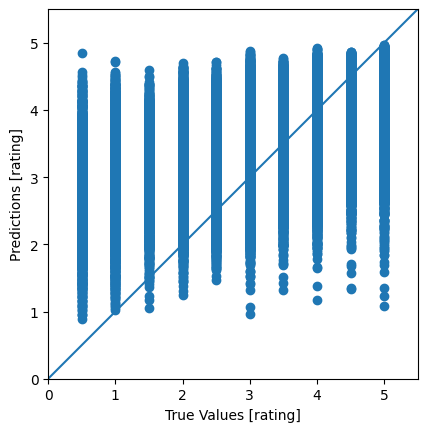

In [390]:
a = plt.axes(aspect='equal')
plt.scatter(y_true * 5, y_pred2)
plt.xlabel('True Values [rating]')
plt.ylabel('Predictions [rating]')
lims = [0, 5.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

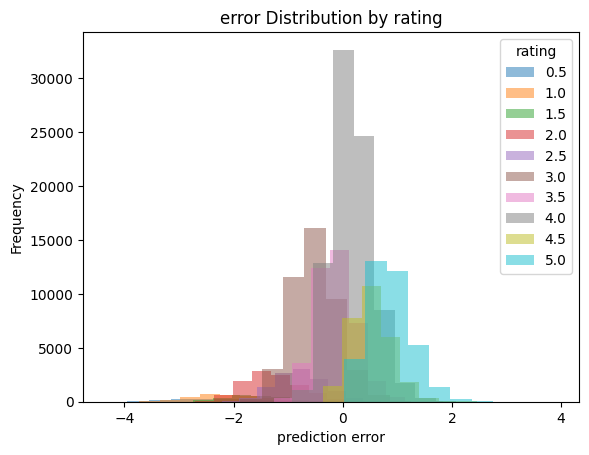

In [391]:
df_pred = pd.DataFrame(columns=['rating','pred'])

df_pred['rating'] = y_true*5
df_pred['pred'] = y_pred2
df_pred['error'] = df_pred['rating'] - df_pred['pred']
liste = sorted(df_pred['rating'].unique())

for j in range(len(liste)):
  plt.hist(df_pred.loc[df_pred['rating'] == liste[j], 'error'], alpha=0.5, label= liste[j])

plt.title('error Distribution by rating')
plt.xlabel('prediction error')
plt.ylabel('Frequency')
plt.legend(title='rating')

In [427]:
def get_hybrid_model2(user_index,movie_title,cosine_sim,indicies,model) :
    idx = indicies[movie_title]
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:10]
    movie_indices = [i[0] for i in sim_scores]
    movies = movies_with_genres(movies_reduced).iloc[movie_indices]
    movies = movies.reset_index()
    index_movies = df[['movieId','new_itemid']].drop_duplicates( keep='first')
    movies = pd.merge(movies,index_movies, on = 'movieId')
    movies['userId'] = user_index
    movie_feat = movies[['new_itemid','Western','Romance', 'Action', 'Film-Noir', 'Animation', 'Mystery', 'Adventure',
    'Sci-Fi','Thriller', 'Horror', 'War', 'Comedy','Children', 'Drama', 'Documentary', 'IMAX','Crime', 'Musical','Fantasy']]
    movies['prediction_rating'] = model.predict([movies.userId, movie_feat])*5
    movies = movies.drop(['userId','movieId','new_itemid','Western','Romance', 'Action', 'Film-Noir', 'Animation', 'Mystery', 'Adventure',
    'Sci-Fi','Thriller', 'Horror', 'War', 'Comedy','Children', 'Drama', 'Documentary', 'IMAX','Crime', 'Musical','Fantasy'],
     axis = 1)
    return movies

In [428]:
get_hybrid_model2(0,'Godfather: Part II, The (1974)',sim , index, nn2)

1/1 [==============================] - 0s 26ms/step


,index,title,genres,count,mean,bayesian_avg,prediction_rating
0,90,Forrest Gump (1994),Comedy|Drama|Romance|War,66172,4.029000,4.018989,3.493243
1,0,"Shawshank Redemption, The (1994)",Crime|Drama,63366,4.446990,4.431666,3.839168
2,19,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,63299,4.177057,4.164868,3.762711
3,750,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,59715,3.664741,3.658166,3.526145
4,14,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,54502,4.190672,4.176358,3.973159
5,81,Braveheart (1995),Action|Drama|War,53769,4.042534,4.030060,3.664604
6,176,Terminator 2: Judgment Day (1991),Action|Sci-Fi,52244,3.931954,3.920682,3.679294
7,16,"Matrix, The (1999)",Action|Sci-Fi|Thriller,51334,4.187186,4.172052,3.983504
8,3,Schindler's List (1993),Drama|War,50054,4.310175,4.292849,3.522725
